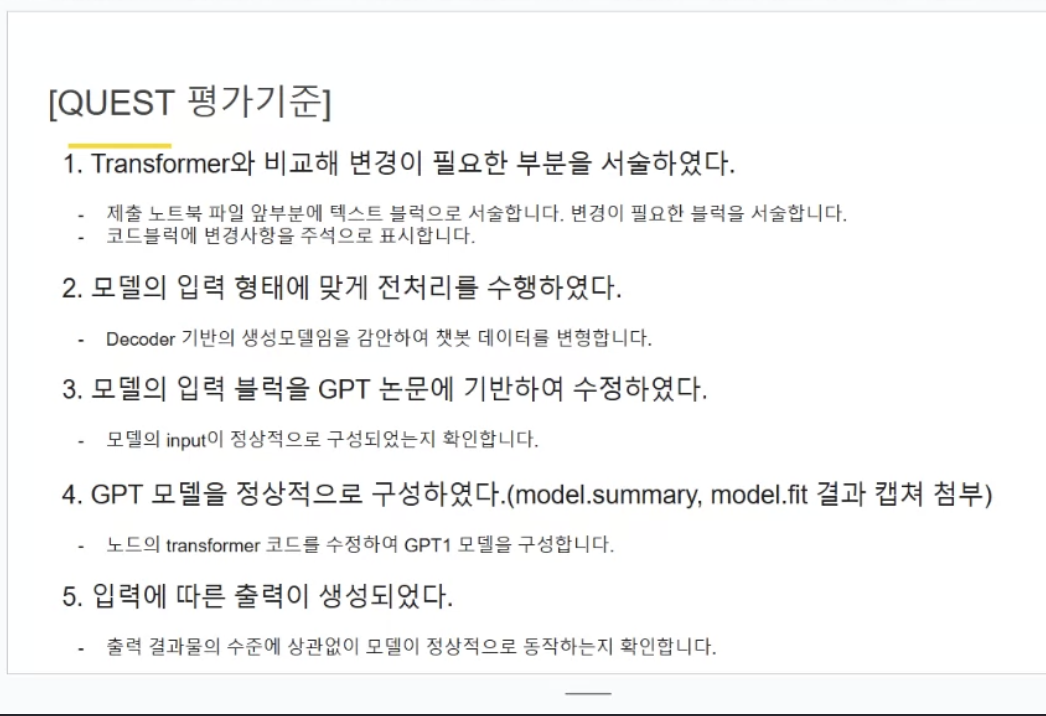

# Tansformer와 비교해 변경이 필요한 부분
- decoder 만 사용할 것이므로 encoder와 관련된 부분을 삭제
    - encoder와 관련된 레이어들 삭제
    -  decoder의 어텐션중 encoder-decoder 어텐션을 삭제

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## 패딩 마스크

In [5]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [6]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


## Look ahead masking

In [7]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [8]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [9]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## encoder (인코더 제외)

In [10]:
# # 인코더 하나의 레이어를 함수로 구현.
# # 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
# def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
#     inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

#     # 패딩 마스크 사용
#     padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#     # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
#     attention = MultiHeadAttention(
#       d_model, num_heads, name="attention")({
#           'query': inputs,
#           'key': inputs,
#           'value': inputs,
#           'mask': padding_mask
#       })

#     # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
#     attention = tf.keras.layers.Dropout(rate=dropout)(attention)
#     attention = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(inputs + attention)

#     # 두 번째 서브 레이어 : 2개의 완전연결층
#     outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
#     outputs = tf.keras.layers.Dense(units=d_model)(outputs)

#     # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
#     outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
#     outputs = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention + outputs)

#     return tf.keras.Model(
#       inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [11]:
# def encoder(vocab_size,
#             num_layers,
#             units,
#             d_model,
#             num_heads,
#             dropout,
#             name="encoder"):
#     inputs = tf.keras.Input(shape=(None,), name="inputs")

#     # 패딩 마스크 사용
#     padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#     # 임베딩 레이어
#     embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
#     embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

#     # 포지셔널 인코딩
#     embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

#     outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

#     # num_layers만큼 쌓아올린 인코더의 층.
#     for i in range(num_layers):
#         outputs = encoder_layer(
#             units=units,
#             d_model=d_model,
#             num_heads=num_heads,
#             dropout=dropout,
#             name="encoder_layer_{}".format(i),
#         )([outputs, padding_mask])

#     return tf.keras.Model(
#       inputs=[inputs, padding_mask], outputs=outputs, name=name)

# Chat Bot

In [12]:
import pandas as pd

data = pd.read_csv('/aiffel/aiffel/workspace/15_main_quest/data/ChatbotData.csv')

In [13]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [14]:
print('전체 갯수',len(data))

전체 갯수 11823


In [15]:
print('결측치\n', data.isnull().sum())

결측치
 Q        0
A        0
label    0
dtype: int64


In [16]:
def preprocess_sentence(df):
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentences = []

    for sentence in df:
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        sentences.append(sentence)

    return sentences

In [17]:
questions = preprocess_sentence(data['Q'])

In [18]:
answers = preprocess_sentence(data['A'])

In [19]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [20]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2
     

In [21]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [22]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


In [23]:
# SubWord Text Tokenizer encode decode 확인

org_string = questions[5]

encode_string = tokenizer.encode(org_string)
print ('정수 인코딩 후의 문장 {}'.format(encode_string))

decode_string = tokenizer.decode(encode_string)
print ('기존 문장: {}'.format(decode_string))

정수 인코딩 후의 문장 [8005, 7990, 2192, 919, 78, 821]
기존 문장: SD카드 망가졌어


In [24]:
# 각 정수는 각 단어와 어떻게 mapping되는지 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for encode in encode_string:
    print(f'{encode} === {tokenizer.decode([encode])}')

8005 === S
7990 === D
2192 === 카드 
919 === 망
78 === 가
821 === 졌어


In [25]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        #  정수 인코딩 + 시작 토큰과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [26]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8180
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [27]:
# 0번째 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [28]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8180
전체 샘플의 수(Number of samples): 11823


## teacher forcing
샘플 : \<START_TOKEN> I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD> \<PAD>

입력 : \<START_TOKEN> I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD>
    
레이블 : I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD> \<PAD>

In [39]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
#         'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨처음 시작 토큰 제거
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)

# 훈련데이터셋 검증 데이터셋 나누기

# 데이터셋 크기 계산
dataset_size = len(questions)

# 2. 데이터셋 분할
train_size = int(0.8 * dataset_size)  # 예시로 80%를 train으로 사용
val_size = dataset_size - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# 배치 및 프리페치 적용
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 3. 데이터셋 크기 확인
print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")


# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
     

Train dataset size: 9458
Validation dataset size: 2365


In [40]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
# print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.
     

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


# Model

In [41]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
#     enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

    # encoder decoder 어텐션을 사용하지 않으니까 주석처리
    # padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

# 인코더-디코더 어텐션 사용 x

#     # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
#     attention2 = MultiHeadAttention(
#       d_model, num_heads, name="attention_2")(inputs={
#           'query': attention1,
#           'key': enc_outputs,
#           'value': enc_outputs,
#           'mask': padding_mask
#       })

#     # 마스크드 멀티 헤드 어텐션의 결과는
#     # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
#     attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
#     attention2 = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    # outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1) # 셀프 어텐션만 한것을 적용
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(
#      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [42]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
#     inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
#     enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

# # Input -> Lambda로 변경
#     look_ahead_mask = tf.keras.Input(
#       shape=(1, None, None), name='look_ahead_mask')

    # Lambda로 look ahead 적용
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
#       output_shape=(1, None, None),
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
    
# 위 look ahead mask에서 내부적으로 패딩 마스크가 적용되기에 주석처리
#     # 패딩 마스크
#     padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

#     # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
#     # 디코더에서 패딩을 위한 마스크
#     padding_mask = tf.keras.layers.Lambda(
#       create_padding_mask,
#       output_shape=(1, 1, None),
#       name='padding_mask')(inputs
#     )


    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(dec_inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        dec_outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask])
        #)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)


    return tf.keras.Model(
#       inputs=[inputs, look_ahead_mask, padding_mask],
      inputs=[dec_inputs],
      outputs=outputs,
      name=name)

In [43]:
# def transformer(vocab_size,
#                 num_layers,
#                 units,
#                 d_model,
#                 num_heads,
#                 dropout,
#                 name="transformer"):
#     inputs = tf.keras.Input(shape=(None,), name="inputs")
#     dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

#     # 인코더 주석 처리 
# #     # 인코더에서 패딩을 위한 마스크
# #     enc_padding_mask = tf.keras.layers.Lambda(
# #       create_padding_mask, output_shape=(1, 1, None),
# #       name='enc_padding_mask')(inputs)

#     # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
#     # 내부적으로 패딩 마스크도 포함되어져 있습니다.
#     look_ahead_mask = tf.keras.layers.Lambda(
#       create_look_ahead_mask,
#       output_shape=(1, None, None),
#       name='look_ahead_mask')(dec_inputs)

# #     # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
# #     # 디코더에서 패딩을 위한 마스크
# #     dec_padding_mask = tf.keras.layers.Lambda(
# #       create_padding_mask, output_shape=(1, 1, None),
# #       name='dec_padding_mask')(inputs)

#     # 인코더 주석처리
# #     # 인코더
# #     enc_outputs = encoder(
# #       vocab_size=vocab_size,
# #       num_layers=num_layers,
# #       units=units,
# #       d_model=d_model,
# #       num_heads=num_heads,
# #       dropout=dropout,
# #     )(inputs=[inputs, enc_padding_mask])

#     # 디코더
#     dec_outputs = decoder(
#       vocab_size=vocab_size,
#       num_layers=num_layers,
#       units=units,
#       d_model=d_model,
#       num_heads=num_heads,
#       dropout=dropout,
#     )(inputs=[dec_inputs, look_ahead_mask])   
#     #)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

#     # 완전연결층
#     outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

#     return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [44]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2
D_MODEL = 256
UNITS = 512
NUM_HEADS = 8
DROPOUT = 0.3

# model = transformer(

model = decoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2094080     dec_inputs[0][0]                 
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, None, 256)    0           embedding[0][0]                  
__________________________________________________________________________________________________
positional_encoding (Positional (None, None, 256)    0           tf.math.multiply[0][0]           
____________________________________________________________________________________________

In [45]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [49]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

EPOCHS = 20

weight_filename = 'best_weights.h5'

# ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    weight_filename,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

import os

if os.path.isfile(weight_filename):
    model.load_weights(weight_filename)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpoint,early_stop]
)

Epoch 1/20
148/148 [==============================] - 6s 35ms/step - loss: 0.8711 - accuracy: 0.0571 - val_loss: 0.8246 - val_accuracy: 0.0584

Epoch 00001: val_accuracy improved from -inf to 0.05838, saving model to best_weights.h5
Epoch 2/20
148/148 [==============================] - 5s 32ms/step - loss: 0.8513 - accuracy: 0.0582 - val_loss: 0.8100 - val_accuracy: 0.0614

Epoch 00002: val_accuracy improved from 0.05838 to 0.06142, saving model to best_weights.h5
Epoch 3/20
148/148 [==============================] - 5s 32ms/step - loss: 0.8197 - accuracy: 0.0601 - val_loss: 0.7673 - val_accuracy: 0.0632

Epoch 00003: val_accuracy improved from 0.06142 to 0.06316, saving model to best_weights.h5
Epoch 4/20
148/148 [==============================] - 5s 33ms/step - loss: 0.7990 - accuracy: 0.0623 - val_loss: 0.7320 - val_accuracy: 0.0664

Epoch 00004: val_accuracy improved from 0.06316 to 0.06640, saving model to best_weights.h5
Epoch 5/20
148/148 [==============================] - 5s 33

## 한 30번 이후로는 거의 변화가 없음

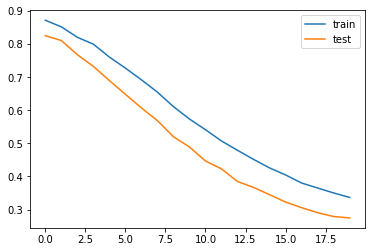

In [50]:
# 훈련결과 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [51]:
def input_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [56]:
def decoder_inference(sentence):
    sentence = input_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

#     # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
#     # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
#         predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = model(inputs=[sentence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
              break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [57]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [62]:
test = data.sample(10)
test_question = test['Q']
test

,Q,A,label
9951,사랑하는 사람과 아침을 함께 맞이하고 싶어,그런 기쁨과 기적도 없을 거예요.,2
8483,행복해져야해,행복할 거라 생각해요.,1
3808,일 때려칠까?,뒷감당은 준비하세요.,0
10240,썸 타다 늙어 죽을 듯,속 타 죽기 전에 표현해보세요.,2
9016,과묵한 타입인건가?,그게 매력포인트가 되기도 하죠.,2
4782,큰일 없이 살고 있어,오늘도 평안했던 하루에 감사하는 마음을 가져보세요.,0
8778,황당하지만 재미난 일이 생겼네ㅎㅎ,무슨 일인지 말씀해주세요.,1
10411,썸일 때도 스킨십 하고 싶어?,자연스러운 현상이에요.,2
1525,말문이 막힌다,생각지도 못한 일이 일어났나봐요.,0
2753,시험 없어지면 좋겠다.,나중에 없애주세요.,0


In [63]:
for question in test_question:
    print('-'*30)
    sentence_generation(question)

------------------------------
Input: 사랑하는 사람과 아침을 함께 맞이하고 싶어
Output: 주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요주세요
------------------------------
Input: 행복해져야해
Output: 요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요
------------------------------
Input: 일 때려칠까?
Output: 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 
------------------------------
Input: 썸 타다 늙어 죽을 듯
Output: 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 
------------------------------
Input: 과묵한 타입인건가?
Output: 좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요좋겠네요
------------------------------
Input: 큰일 없이 살고 있어
Output:                                         
------------------------------
Input: 황당하지만 재미난 일이 생겼네ㅎㅎ
Output: 하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠하죠

In [ ]:
print('-'*30)
sentence_generation('그시절엔 다그랬나')
print('-'*30)
sentence_generation('듬직한 사람이 좋아?')
print('-'*30)
sentence_generation('바쁘다')
print('-'*30)
sentence_generation('좋아하는 사람 언제까지 기다릴 수 있을까?')
print('-'*30)
sentence_generation('할 말이 많음')
print('-'*30)
sentence_generation('나는 혼술이 좋아')
print('-'*30)
sentence_generation('혼술중')
print('-'*30)
sentence_generation('눈이또와')
print('-'*30)
sentence_generation('나 우울해 위로해줘')
print('-'*30)
sentence_generation('부케가 뭘로할까')
